# This jupyter notebook is prepared by Alain Ambrose

# A5 Convolutional Neural Network (Total 150pts)


## 1. Import libraries (Total 6pts)

### 1.1 Import torch, torchvision, torchvision.transforms, torch.utils.data and torch.nn (6pts)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.nn as nn

## 2. Data Preparation (Total 32pts)


### 2.1 Image Transformation (12pts)
Define a transformation pipeline using torchvision.transforms.Compose.

In the pipeline, use **ColorJitter, GaussianBlur, RandomHorizontalFlip, ToTensor and Normalize** from the transforms library.

For the first four transformations, use suitable parameters of your informed choice. At the end, normalize the images with mean 0.5 and variance 0.5.

Read about these transformations here: https://pytorch.org/vision/0.9/transforms.html

In [2]:
transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

### 2.2 Prepare train and test set by loading CIFAR10 dataset from torchvision.datasets. (4pts)
Make sure you are using the **transform** pipeline (you just wrote in task #2.1) on both train and test set. 

**Hint:** Preparing train and test sets can be directly achieved by utilizing the class parameters.


Read about CIFAR10 dataset class in PyTorch: https://pytorch.org/vision/0.9/datasets.html#cifar

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:11<00:00, 15342309.50it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 2.3 Use torch.utils.data.random_split() to make a validation set from the training set with 80:20 split. (3pts)

Make sure the training set you'll use after this point excludes the validation set of images 


In [4]:
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

### 2.4 Prepare three dataloaders for train, validation and test set. Use an appropriate batchsize of your choice. (1+2+2+2 =7pts)


**Hints:**
1. Remember that choosing a batchsize is always a trade-off between efficiency and generalizability. With large batchsize, your model learns more and better in each forward pass, but each pass will require larger computation. On the other hand, with small batchsize, it might converge quicker, but each forward pass teaches features from a smaller subset, which may not be a good representation of the overall data; leading to jittery convergence.
2. During training, you will use the train and validation set for tracking the loss and avoiding overfitting. The test set will be hold out until you are ready to evaluate a trained model on new data. 

Read about pytorch Dataloaders here:
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders

In [5]:
# TODO: set a batch size
batch_size = 32;

# TODO: write dataloader for train set
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True, num_workers=2)

# TODO: write dataloader for test set
valloader = torch.utils.data.DataLoader(valset, batch_size, shuffle=False, num_workers=2)

# TODO: write dataloader for validation set
testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=False, num_workers=2)


### 2.5 Load a random batch of images from the training set using the trainloader. Then use *make_grid()*  from *torchvision.utils* and *imshow()* from *matplotlib.pyplot* to show the images. Also, print the corresponding true labels for those image samples. (6pts)
Hint: you may need to reshape the *make_grid()* output to comply with the format *imshow()* accepts.

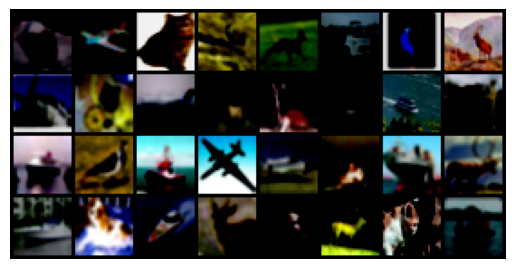

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# TODO: load a random batch of test set images
dataiter = iter(trainloader)
images, labels = dataiter.__next__()

# TODO: show the images
img_grid = torchvision.utils.make_grid(images)
img_np = np.transpose(img_grid.numpy(), (1, 2, 0))
plt.imshow(img_np)
plt.axis('off')
plt.show()

# TODO: print the ground truth class labels for these images
print('True Labels: ', ' '.join('%5s' % trainset.dataset.classes[labels[j]] for j in range(len(labels))))


## 3. Model Design (Total 22pts)

### 3.1 Define a neural network model: (2+7+7 =16pts)
- Name the model class with your first name
- In the following sequential order, the model should consist:

    (1) a 2D convolution layer with 6 filters, dimension of each filter is (5, 5), stride=1, no zero padding
    
    (2) a Max Pool layer with filter size (2, 2), stride=2
    
    (3) a 2D convolution layer with 16 filters, dimension of each filter is (5, 5), stride=1, no zero padding

    (4) a 2D Max Pool layer with filter size (2, 2), stride=2
    
    ~ a flatten layer ~

    (5) a Dense/Fully-connected layer with 120 neurons
    
    ~ a ReLU activation ~
    
    ~ a Dropout Layer ~

    (6) a Dense/Fully-connected layer with 80 neurons
    
    ~ a ReLU activation ~

    (7) a Dense/Fully-connected layer with 10 neurons

Note: 
1. Flatten, ReLU and Dropout are not really "layers". They are operations with specific purpose. But in model construction in pytorch, they are abstracted as layers.
    
    Flatten is used to convert the 4th layer output to a 1D tensor so that it can be passed through the next fully-connected layer. Since each forward pass takes a batch of data, use the *start_dim* parameter of *torch.flatten()* appropriately to keep the batch dimension intact.
    
    ReLU is an activation that transforms the Dense Layer's linear output to a non-linear "active" output.
    
    Dropout is a regularization technique. Read more in slides. In this assignment, you can drop neurons with 50% probability. 

2. This dataset has 10 classes, hence the final layer consists 10 neurons. 

3. The model architecture is similar to the one you saw in in-class Quiz 2, with an extra dense layer in the end. 

    Read about building your custom model in pytorch here: https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html

    The official pytorch documentation on conv, flatten, rely, dense are also resourceful.


In [7]:
class Alain(nn.Module):
    def __init__(self):
        super(Alain, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5, 5), stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=120, out_features=80)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=80, out_features=10)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

True Labels:    cat airplane   cat  deer  deer truck  bird  deer airplane   cat airplane  deer  deer  deer  ship horse  ship  bird  ship airplane airplane  ship  ship  deer  ship   dog  ship  deer horse  deer   cat  ship


### 3.2 Create an instance of the model class that you just prepared. (2pts)

In [8]:
model = Alain()

### 3.3 Set up Cross Entropy Loss as the loss function and *Adam* as the optimizer. Use a learning rate of your choice for the optimizer. (4pts) 


In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 4. Training and Validation (Total 50pts)


### 4.1 Write a training loop to load data, compute model output, compute loss and backpropagating it to update model parameters. (30pts)

The # TODO tags below contain further instructions. 

In [10]:
# TODO: Define number of epochs
num_epochs = 10

# TODO: Initialize empty lists to store training loss, training accuracy, validation loss, validation accuracy 
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

# TODO: Loop through the number of epochs
for epoch in range(num_epochs):
    
    # TODO: set model to train mode
    model.train()

    # TODO: initialize train loss and accuracy for the current epoch
    epoch_train_loss = 0.0
    epoch_train_acc = 0.0
    num_train_batches = 0

    # TODO: iterate over the training data in batches
    for i, (images, labels) in enumerate(trainloader):

        # TODO: get the image inputs and labels from current batch
        images = images.to()
        labels = labels.to()

        # TODO: set the optimizer gradients to zero to avoid accumulation of gradients
        optimizer.zero_grad()

        # TODO: compute the output of the model
        outputs = model(images)

        # TODO: compute the loss on current batch
        loss = criterion(outputs, labels)

        # TODO: backpropagate the loss
        loss.backward()

        # TODO: update the optimizer parameters
        optimizer.step()

        # TODO: update the train loss and accuracy for the current epoch
        epoch_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        epoch_train_acc += (predicted == labels).sum().item() / labels.size(0)
        num_train_batches += 1

    # TODO: compute the average training loss and accuracy for the current epoch
    avg_train_loss = epoch_train_loss / num_train_batches
    avg_train_acc = epoch_train_acc / num_train_batches

    # TODO: set the model to evaluation mode
    model.eval()

    # TODO: initialize validation loss and accuracy for the current epoch
    epoch_val_loss = 0.0
    epoch_val_acc = 0.0
    num_val_batches = 0

    # TODO: keeping the gradient computation turned off, loop over batches of data from validation set.
    with torch.no_grad():
        for images, labels in valloader:

            # TODO: compute output of the model
            images = images.to()
            labels = labels.to()
            outputs = model(images)

            # TODO: compute the loss
            loss = criterion(outputs, labels)

            # TODO: update the validation loss and accuracy for the current epoch
            epoch_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            epoch_val_acc += (predicted == labels).sum().item() / labels.size(0)
            num_val_batches += 1

    # TODO: compute the average validation loss and accuracy for the current epoch
    avg_val_loss = epoch_val_loss / num_val_batches
    avg_val_acc = epoch_val_acc / num_val_batches

    # TODO: append the average training loss and accuracy, and validation loss and accuracy for the current epoch to their respective lists
    train_loss_history.append(avg_train_loss)
    train_acc_history.append(avg_train_acc)
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(avg_val_acc)

    # TODO: print the training loss, training accuracy, validation loss and validation accuracy at the end of each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Train Acc: {avg_train_acc:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Acc: {avg_val_acc:.4f}")

    # TODO: save the model parameters once in every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), f"model_params_epoch{epoch + 1}.pt")


Epoch [1/10], Train Loss: 1.7757, Train Acc: 0.3567, Val Loss: 1.5312, Val Acc: 0.4506
Epoch [2/10], Train Loss: 1.5629, Train Acc: 0.4393, Val Loss: 1.4252, Val Acc: 0.4948
Epoch [3/10], Train Loss: 1.4840, Train Acc: 0.4703, Val Loss: 1.3798, Val Acc: 0.5179
Epoch [4/10], Train Loss: 1.4263, Train Acc: 0.4890, Val Loss: 1.3567, Val Acc: 0.5213
Epoch [5/10], Train Loss: 1.3942, Train Acc: 0.5030, Val Loss: 1.2998, Val Acc: 0.5428
Epoch [6/10], Train Loss: 1.3650, Train Acc: 0.5126, Val Loss: 1.2968, Val Acc: 0.5465
Epoch [7/10], Train Loss: 1.3336, Train Acc: 0.5253, Val Loss: 1.2404, Val Acc: 0.5658
Epoch [8/10], Train Loss: 1.3169, Train Acc: 0.5333, Val Loss: 1.2475, Val Acc: 0.5640
Epoch [9/10], Train Loss: 1.3007, Train Acc: 0.5415, Val Loss: 1.2287, Val Acc: 0.5721
Epoch [10/10], Train Loss: 1.2912, Train Acc: 0.5433, Val Loss: 1.2124, Val Acc: 0.5731


### 4.2 Plot and compare (5+5 =10pts)
1. training and validation loss over the number of epochs
2. training and validation accuracy over the number of epochs

(Hint: Use plot() from *matplotlib.pyplot*, import it if you haven't already done so.)

10


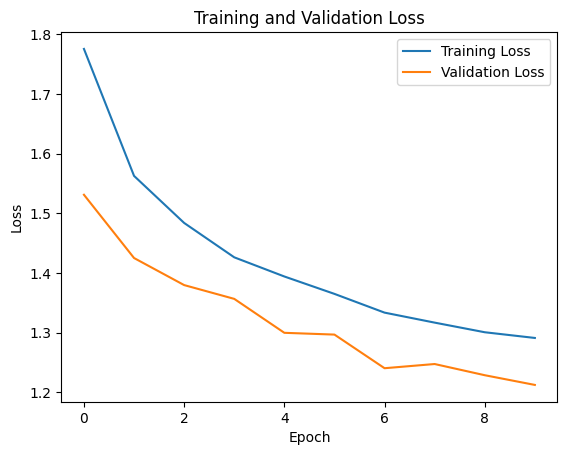

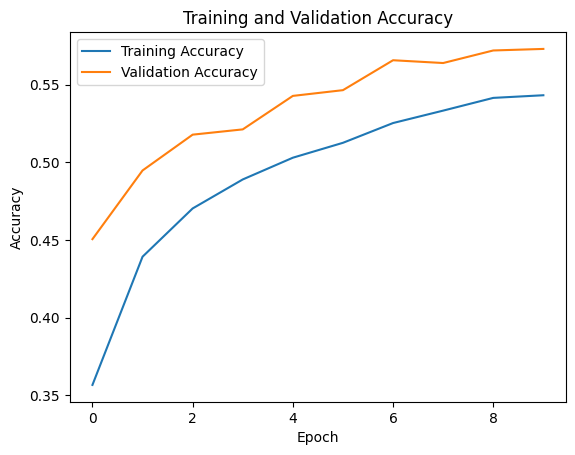

In [11]:
print(len(train_loss_history))
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### 4.3 Discussion: (2*5 = 10pts)
(1) Does the training loss and accuracy improve as number of epoch increases?

Training loss and accuracy improve as the number of epochs increases.

(2) Does the validation loss and accuracy improve as number of epoch increases?

Validation loss and accuracy improve as the number of epochs increases.

(3) Are there any sign of overfitting in the results? If so, when did it start to occur?

(4) How many epochs did it take for the model to converge to a good solution?

(5) What enhancement can be tried to the architecture to further improve the validation performance?

~ # TODO

## 5. Testing on new data (Total 40pts)


### 5.1 Load the best performing model (one with good validation accuracy and without overfitting) among the ones you saved. (4pts)

In [19]:
# TODO: instantiate a model
model = Alain()

# TODO: load parameters from one of the saved model states
model.load_state_dict(torch.load(f'model_params_epoch{10}.pt'))

# TODO: set this model to evaluation mode 
model.eval()


Alain(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)

### 5.2 Take a random batch of images from test set and show the images. Print the corresponding ground truth class labels. Then compute model output (model selected at previous step) and the predicted labels for the images in this batch. (10pts)

This is similar to task #2.5 with additional task on computing model output and printing predicted labels.

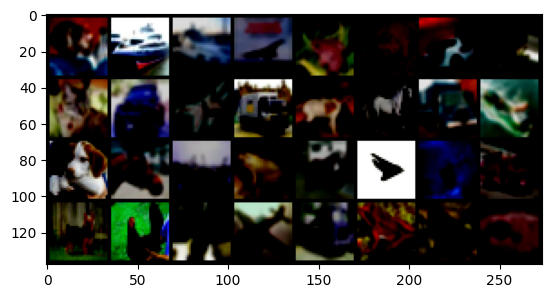

Ground Truth Labels:    cat  ship  ship airplane  frog  frog automobile  frog   cat automobile airplane truck   dog horse truck  ship   dog horse  ship  frog horse airplane  deer truck   dog  bird  deer airplane truck  frog  frog   dog
Predicted Labels:    cat  ship  ship airplane   cat  frog automobile  frog   dog automobile  deer truck  frog horse truck  ship   dog truck  ship  frog horse airplane airplane truck  deer  frog  deer  deer automobile  frog  frog  deer


In [21]:
# TODO: load a random batch of test set images
dataiter = iter(testloader)
images, labels = dataiter.__next__()

# TODO: show the images
plt.imshow(torchvision.utils.make_grid(images).permute(1, 2, 0))
plt.show()

# TODO: print the ground truth class labels for these images
print('Ground Truth Labels: ', ' '.join('%5s' % trainset.dataset.classes[labels[j]] for j in range(len(labels))))

# TODO: compute model output
outputs = model(images.to())

# TODO: print the predicted class labels for these images
_, predicted = torch.max(outputs, 1)
print('Predicted Labels: ', ' '.join('%5s' % trainset.dataset.classes[predicted[j]] for j in range(len(predicted))))


### 5.3 Compute the average accuracy on test data using this model. (4+2 =6pts)
Loop over the test set, compute accuracy on each batch, lastly print the average accuracy. 

In [23]:
# TODO: compute accuracy on each batch of test set
num_correct = 0
num_samples = 0

# Loop over the test set
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

        num_correct += (predicted == labels).sum().item()
        num_samples += labels.size(0)

# TODO: print the average accuracy
avg_accuracy = num_correct / num_samples
print('Average accuracy on test set: {:.2f}%'.format(avg_accuracy * 100))



Average accuracy on test set: 57.47%


### 5.4 Compute the average accuracy for each individual class. (8+4 =12pts)
Hint: similar to #5.3. During each loop, log the accuracy for each class separately (a python/numpy dictionary can help). Then print the individual accuracy for the 10 output classes. 

In [26]:
# TODO: compute per-class accuracy on each batch of test set
class_counts = {}
correct_counts = {}

# Loop over test set batches
for batch_idx, (images, labels) in enumerate(testloader):

    output = model(images)

    _, predicted = torch.max(output, 1)

    for i in range(len(labels)):
        true_label = int(labels[i])
        predicted_label = int(predicted[i])
        if true_label in class_counts:
            class_counts[true_label] += 1
        else:
            class_counts[true_label] = 1
        if predicted_label == true_label:
            if true_label in correct_counts:
                correct_counts[true_label] += 1
            else:
                correct_counts[true_label] = 1

# TODO: print per-class accuracy for 10 output classes
for i in range(10):
    if i in class_counts:
        accuracy = 100.0 * correct_counts.get(i, 0) / class_counts[i]
        print(f"Accuracy for class {i}: {accuracy:.2f}%")
    else:
        print(f"No instances found for class {i}")


Accuracy for class 0: 71.00%
Accuracy for class 1: 68.70%
Accuracy for class 2: 31.80%
Accuracy for class 3: 33.10%
Accuracy for class 4: 57.50%
Accuracy for class 5: 48.30%
Accuracy for class 6: 69.40%
Accuracy for class 7: 61.60%
Accuracy for class 8: 70.40%
Accuracy for class 9: 65.10%


### 5.5 Discussion: (2+2+4 =8pts)
1. Which class of images were detected with highest accuracy? 

The first class that was detected with the highest accuracy of about 71%.

2. Which class of images were hardest for the model to detect? 

The model had a very hard time detecting the third class which only had about 31% accuracy.

3. Explain 1-2 possible reasons why detection of some class can be harder for the same model. 

One major reason why detection of classes can be harder for the same model is an imbalance in the training set. This can make the model more equipped to detect certain images against others. 

Another reason is that the pictures a model might be trying to detect might be too close in their distinctions and the model has a hard time differentiating the subtle differences between them.

~ # TODO